# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1

In this notebook, we will implement a computer vision system for product identification using template matching. Template matching is a technique used to locate instances of a template image (or pattern) within a larger image. Our goal is to develop a system that can accurately detect instances of products in store shelves from scene images, using reference images provided for each product.

Importing data from Google Drive folder.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

Mounted at /content/drive
Archive:  dataset.zip
   creating: dataset/
  inflating: __MACOSX/._dataset      
   creating: dataset/scenes/
  inflating: __MACOSX/dataset/._scenes  
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/models/
  inflating: __MACOSX/dataset/._models  
  inflating: dataset/scenes/scene12.png  
  inflating: __MACOSX/dataset/scenes/._scene12.png  
  inflating: dataset/scenes/scene10.png  
  inflating: __MACOSX/dataset/scenes/._scene10.png  
  inflating: dataset/scenes/scene11.png  
  inflating: __MACOSX/dataset/scenes/._scene11.png  
  inflating: dataset/scenes/scene5.png  
  inflating: __MACOSX/dataset/scenes/._scene5.png  
  inflating: dataset/scenes/scene4.png  
  inflating: __MACOSX/dataset/scenes/._scene4.png  
  inflating: dataset/scenes/scene6.png  
  inflating: __MACOSX/dataset/scenes/._scene6.png  
  inflating: dataset/scenes/scene7.png  
  inflating: __MACOSX/dataset/scenes/._scene7.png  
  inflating: 

As usual, let's start by importing the necessary Python libraries for our project:

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

Before we begin, we need to visualize an example scene image to understand the type of noise present and its effect on the image quality. There are several types of noise that can corrupt an image, including Gaussian noise, salt-and-pepper noise, and speckle noise.


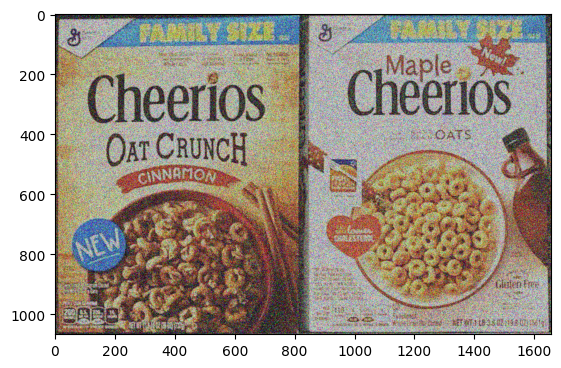

In [4]:
image = cv2.imread('dataset/scenes/scene1.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.show()

Zooming into a homogeneous area allows us to closely examine the image details.

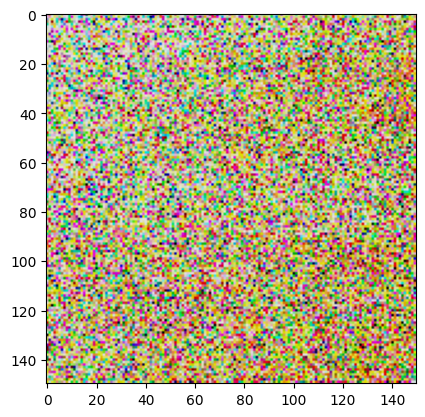

In [5]:
flat_region = image_rgb[400:550, 650:800]

plt.imshow(flat_region)
plt.show()

We visualize the histogram of the flat region.

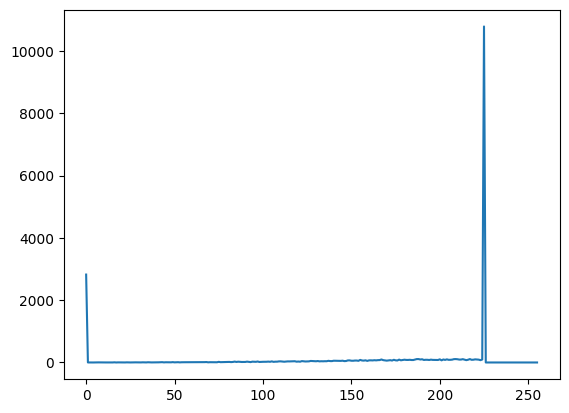

In [6]:
histr = cv2.calcHist([flat_region],[0],None,[256],[0,256])
plt.plot(histr)
plt.show()

We apply the median filter to remove impulse noise, such as salt-and-pepper noise, which can distort the appearance of objects in the image.

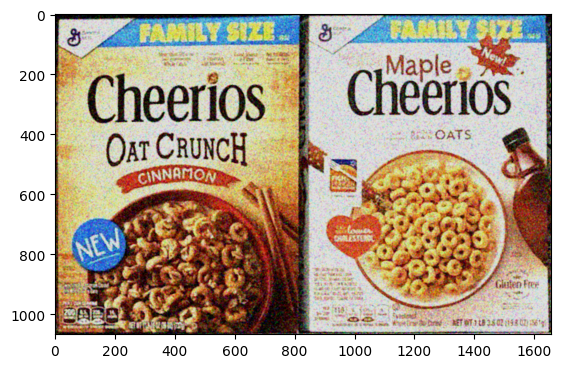

In [7]:
filtered_image = cv2.medianBlur(image_rgb, 5)

plt.imshow(filtered_image)
plt.show()

# Track A - Single Instance Detection

In this section, we'll focus on detecting a single instance of each product in the scene images. We'll iterate over each scene image and reference image pair and apply the template matching algorithm to detect instances of products.







We'll start by loading the reference images for Track A, which includes {ref1.png to ref14.png}. These images represent one reference image for each product that the system should be able to identify.

In [9]:
ref_images = {}
ref_paths = [f"dataset/models/ref{i+1}.png" for i in range(14)]

for ref_path in ref_paths:
  name, _ = os.path.splitext(os.path.basename(ref_path))
  ref_img = cv2.imread(ref_path)
  ref_images[name] = ref_img

Next, we'll load the scene images for Track A, which includes {scene1.png to scene5.png}. These images represent different shelf pictures to test the developed algorithm in different scenarios.

In [10]:
scene_images = {}
scene_paths = [f"dataset/scenes/scene{i+1}.png" for i in range(5)]

for scene_path in scene_paths:
  name, _ = os.path.splitext(os.path.basename(scene_path))
  scene_img = cv2.imread(scene_path)
  scene_images[name] = scene_img

We apply denoising techniques to the scene images using the filters studied earlier.

In [11]:
preprocessed_scenes = {}

for scene_name, scene_img in scene_images.items():
  filtered_img = cv2.medianBlur(scene_img, 5)
  preprocessed_scenes[scene_name] = filtered_img

# Template Matching Algorithm

## Overview

Template matching involves sliding a template image over a larger image and computing a similarity score at each position. The position with the highest similarity score indicates the location of the template within the larger image.

## Steps

1. Load the reference image and scene image.
2. Convert both images to grayscale for simplicity.
3. Choose a template matching method (e.g., correlation coefficient, squared difference).
4. Apply template matching to find instances of the template in the scene.
5. Post-process the results (e.g., thresholding, non-maximum suppression) to refine the detections.

In [12]:
def non_max_suppression(boxes, overlap_thresh):
  if len(boxes) == 0:
    return []

  if boxes.dtype.kind == "f":
    boxes = boxes.astype("int")

  picked_boxes = []

  x1 = boxes[:, 0]
  y1 = boxes[:, 1]
  x2 = boxes[:, 2]
  y2 = boxes[:, 3]

  areas = (x2 - x1 + 1) * (y2 - y1 + 1)
  order = np.argsort(y2)

  while len(order) > 0:
    i = order[-1]
    picked_boxes.append(i)

    xx1 = np.maximum(x1[i], x1[order[:-1]])
    yy1 = np.maximum(y1[i], y1[order[:-1]])
    xx2 = np.minimum(x2[i], x2[order[:-1]])
    yy2 = np.minimum(y2[i], y2[order[:-1]])

    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    overlap = (w * h) / areas[order[:-1]]
    order = order[np.where(overlap <= overlap_thresh)[0]]

  return boxes[picked_boxes]

In [13]:
def template_matching(scene_img, model_img, th=0.7, overlap_th=0.25, scale_ranges=(0.2, 1.0), num_scales=50):
  gray_scene = cv2.cvtColor(scene_img, cv2.COLOR_BGR2GRAY)
  gray_model = cv2.cvtColor(model_img, cv2.COLOR_BGR2GRAY)

  # Initialize list to store bounding boxes
  bounding_boxes = []
  rects = []

  w_img, h_img = gray_scene.shape[::-1]
  for scale in np.linspace(scale_ranges[0], scale_ranges[1], num_scales):
    resized = cv2.resize(gray_model, (int(gray_model.shape[1] * scale), int(gray_model.shape[0] * scale)))
    r = gray_model.shape[1] / float(resized.shape[1])

    if resized.shape[0] > h_img or resized.shape[1] > w_img:
      break

    res = cv2.matchTemplate(gray_scene, resized, cv2.TM_CCOEFF_NORMED)
    loc = np.where(res >= th)

    for pt in zip(*loc[::-1]):
      rects.append((pt[0], pt[1], pt[0] + resized.shape[1], pt[1] + resized.shape[0]))

  pick = non_max_suppression(np.array(rects), overlap_thresh=overlap_th)

  for (startX, startY, endX, endY) in pick:
    w, h = (abs(startX - endX), abs(startY - endY))
    x_center = startX + w // 2
    y_center = startY + h // 2

    bounding_boxes.append({
        "position": (x_center, y_center),
        "width": w,
        "height": h
    })

  return bounding_boxes

We apply the algoritgm above for all the scenes:

Processing scene6
Product ref15 - 3 instance(s) found:
Instance 1: position: (603, 619), width: 326px, height: 906px
Instance 2: position: (178, 634), width: 315px, height: 876px
Instance 3: position: (933, 625), width: 320px, height: 891px




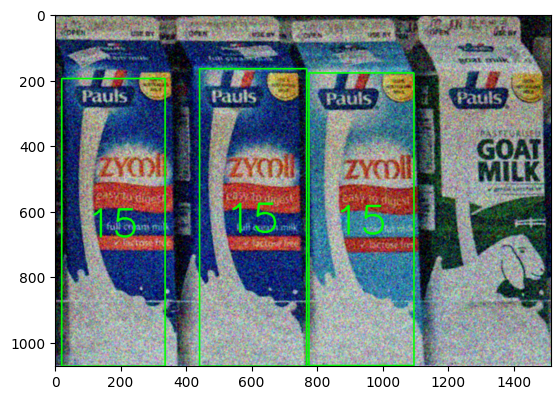

Processing scene7
Product ref16 - 2 instance(s) found:
Instance 1: position: (801, 458), width: 222px, height: 616px
Instance 2: position: (1035, 468), width: 215px, height: 596px




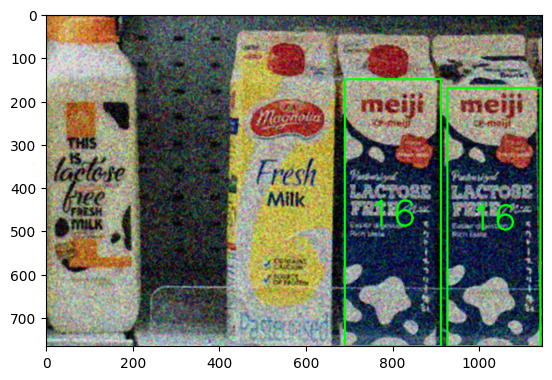

Processing scene8
Product ref17 - 3 instance(s) found:
Instance 1: position: (1341, 581), width: 326px, height: 854px
Instance 2: position: (990, 580), width: 326px, height: 854px
Instance 3: position: (650, 575), width: 326px, height: 854px
Product ref23 - 3 instance(s) found:
Instance 1: position: (1340, 574), width: 326px, height: 880px
Instance 2: position: (988, 574), width: 326px, height: 880px
Instance 3: position: (646, 567), width: 326px, height: 880px
Product ref24 - 3 instance(s) found:
Instance 1: position: (1338, 583), width: 331px, height: 862px
Instance 2: position: (989, 583), width: 331px, height: 862px
Instance 3: position: (644, 578), width: 331px, height: 862px




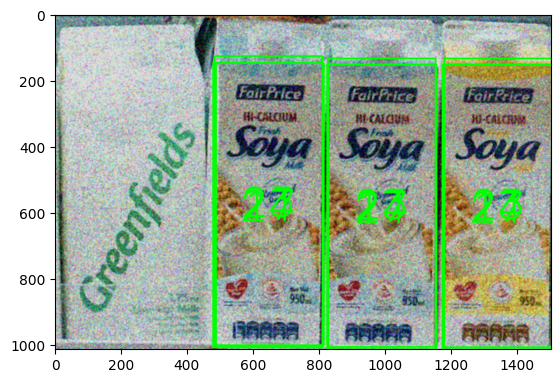

Processing scene9
Product ref19 - 2 instance(s) found:
Instance 1: position: (852, 381), width: 226px, height: 562px
Instance 2: position: (622, 378), width: 226px, height: 562px
Product ref20 - 1 instance(s) found:
Instance 1: position: (1362, 381), width: 232px, height: 562px




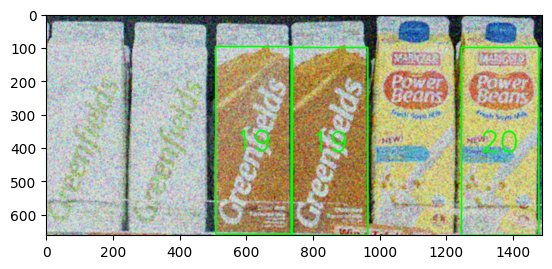

Processing scene10
Product ref21 - 2 instance(s) found:
Instance 1: position: (982, 543), width: 249px, height: 703px
Instance 2: position: (710, 542), width: 249px, height: 703px
Product ref22 - 3 instance(s) found:
Instance 1: position: (1262, 546), width: 256px, height: 721px
Instance 2: position: (982, 542), width: 256px, height: 721px
Instance 3: position: (1527, 539), width: 249px, height: 703px




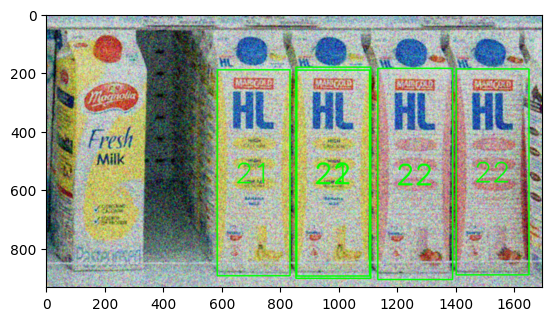

Processing scene11
Product ref17 - 3 instance(s) found:
Instance 1: position: (556, 368), width: 187px, height: 491px
Instance 2: position: (360, 368), width: 187px, height: 491px
Instance 3: position: (166, 366), width: 187px, height: 491px
Product ref23 - 3 instance(s) found:
Instance 1: position: (358, 365), width: 184px, height: 497px
Instance 2: position: (556, 364), width: 184px, height: 497px
Instance 3: position: (164, 360), width: 184px, height: 497px
Product ref24 - 3 instance(s) found:
Instance 1: position: (555, 372), width: 187px, height: 487px
Instance 2: position: (357, 371), width: 187px, height: 487px
Instance 3: position: (165, 367), width: 187px, height: 487px
Product ref25 - 3 instance(s) found:
Instance 1: position: (1343, 383), width: 193px, height: 503px
Instance 2: position: (1143, 381), width: 193px, height: 503px
Instance 3: position: (943, 378), width: 193px, height: 503px




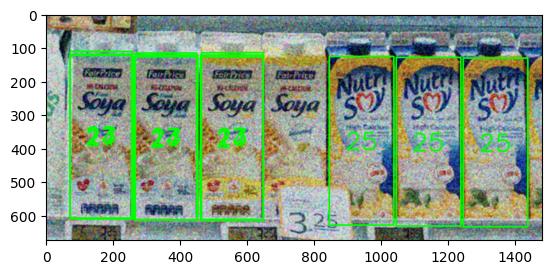

Processing scene12
Product ref26 - 2 instance(s) found:
Instance 1: position: (411, 398), width: 234px, height: 597px
Instance 2: position: (140, 387), width: 234px, height: 597px
Product ref27 - 1 instance(s) found:
Instance 1: position: (954, 401), width: 257px, height: 597px




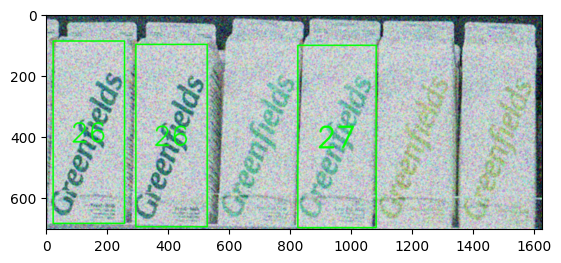

In [20]:
def generate_output(results, scene_img, show_bounding_boxes=False, show_label=False):
  scene_img_copy = scene_img.copy()


  for product_id, result in results.items():
    product_id_number = product_id[3:]
    print("Product", product_id, "-", result["instances_found"], "instance(s) found:")

    for i, bbox in enumerate(result["bounding_boxes"], 1):
      print(f"Instance {i}: position: {bbox['position']}, width: {bbox['width']}px, height: {bbox['height']}px")

      if show_bounding_boxes:
        pt = bbox['position']
        w = bbox['width']
        h = bbox['height']

        tl = (int(pt[0] - w / 2), int(pt[1] - h / 2))
        br = (int(pt[0] + w / 2), int(pt[1] + h / 2))
        cv2.rectangle(scene_img_copy, tl, br, (0, 255, 0), 3
                      )
        if show_label:
          font_scale = w / 80
          thickness = int(w / 50)
          text_size, _ = cv2.getTextSize(product_id_number,
                                         fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                         fontScale=font_scale,
                                         thickness=thickness)

          text_x = pt[0] - text_size[0] // 2
          text_y = pt[1] + text_size[1] // 2

          cv2.putText(scene_img_copy,
                      text=product_id_number,
                      org=(text_x, text_y),
                      fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                      fontScale=font_scale,
                      color=(0, 255, 0),
                      thickness=thickness,
                      lineType=cv2.LINE_AA)
  print("\n")

  if show_bounding_boxes:
    plt.imshow(cv2.cvtColor(scene_img_copy, cv2.COLOR_BGR2RGB))
    plt.show()

##########################################################

for scene_name, scene_img in preprocessed_scenes.items():
  print(f"Processing {scene_name}")
  results = {}

  for ref_name, ref_img  in ref_images.items():
    bounding_boxes = template_matching(scene_img, ref_img)

    if bounding_boxes:
      product_id = os.path.splitext(ref_name)[0]
      results[product_id] = {
          "instances_found": len(bounding_boxes),
          "bounding_boxes": bounding_boxes
      }

  generate_output(results, scene_img, show_bounding_boxes=True, show_label=True)

# Track B - Multiple Instances Detection

Building upon the previous section, we'll enhance our system to detect multiple instances of the same product within a scene image. We'll iterate over each scene image and reference image pair and extend the template matching algorithm to handle multiple detections.

We load the reference images for Track B, which includes {ref15.png to ref27.png}. These additional images will expand the range of products that the system can identify.

In [15]:
ref_images = {}
ref_paths = [f"dataset/models/ref{i+15}.png" for i in range(13)]

for ref_path in ref_paths:
  name, _ = os.path.splitext(os.path.basename(ref_path))
  ref_img = cv2.imread(ref_path)
  ref_images[name] = ref_img

Finally, we'll load the scene images for Track B, which includes {scene6.png to scene12.png}. These images provide further test cases for detecting multiple instances of the same product within a scene.

In [16]:
scene_images = {}
scene_paths = [f"dataset/scenes/scene{i+6}.png" for i in range(7)]

for scene_path in scene_paths:
  name, _ = os.path.splitext(os.path.basename(scene_path))
  scene_img = cv2.imread(scene_path)
  scene_images[name] = scene_img

We apply denoising techniques to the scene images using the filters studied earlier.

In [17]:
preprocessed_scenes = {}

for scene_name, scene_img in scene_images.items():
  filtered_img = cv2.medianBlur(scene_img, 5)
  preprocessed_scenes[scene_name] = filtered_img

Processing scene6
Product ref15 - 3 instance(s) found:
Instance 1: position: (603, 619), width: 326px, height: 906px
Instance 2: position: (201, 630), width: 318px, height: 883px
Instance 3: position: (939, 625), width: 322px, height: 894px




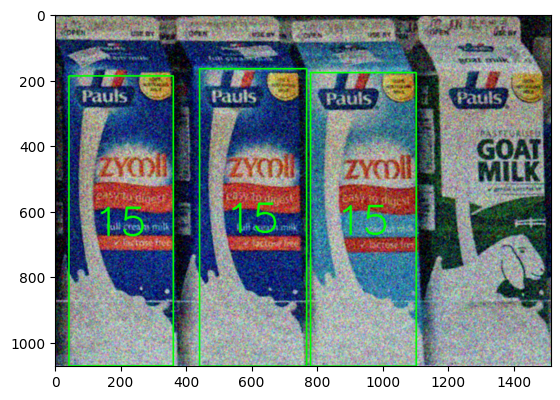

Processing scene7
Product ref16 - 2 instance(s) found:
Instance 1: position: (801, 458), width: 222px, height: 616px
Instance 2: position: (1037, 465), width: 217px, height: 601px




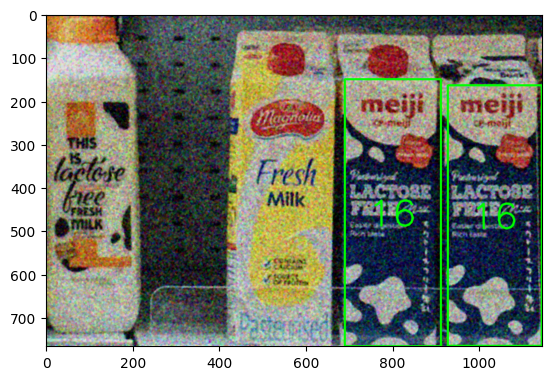

Processing scene8
Product ref17 - 3 instance(s) found:
Instance 1: position: (1341, 581), width: 326px, height: 854px
Instance 2: position: (990, 580), width: 326px, height: 854px
Instance 3: position: (647, 575), width: 326px, height: 854px
Product ref23 - 3 instance(s) found:
Instance 1: position: (990, 568), width: 330px, height: 892px
Instance 2: position: (1337, 574), width: 326px, height: 880px
Instance 3: position: (646, 567), width: 326px, height: 880px
Product ref24 - 3 instance(s) found:
Instance 1: position: (1338, 583), width: 331px, height: 862px
Instance 2: position: (989, 583), width: 331px, height: 862px
Instance 3: position: (646, 578), width: 331px, height: 862px




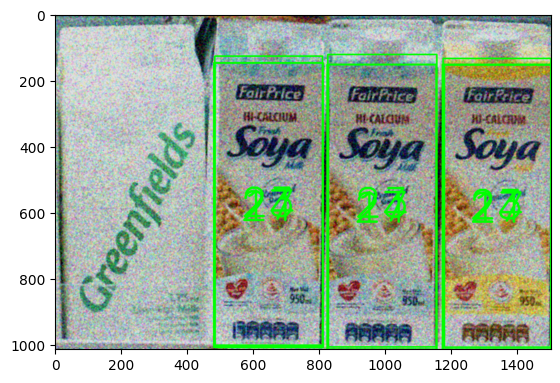

Processing scene9
Product ref19 - 2 instance(s) found:
Instance 1: position: (852, 381), width: 226px, height: 562px
Instance 2: position: (622, 378), width: 226px, height: 562px
Product ref20 - 1 instance(s) found:
Instance 1: position: (1362, 381), width: 232px, height: 562px




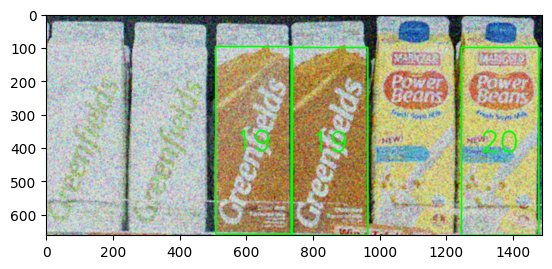

Processing scene10
Product ref21 - 2 instance(s) found:
Instance 1: position: (711, 544), width: 254px, height: 717px
Instance 2: position: (982, 543), width: 249px, height: 703px
Product ref22 - 3 instance(s) found:
Instance 1: position: (1262, 546), width: 254px, height: 717px
Instance 2: position: (983, 541), width: 254px, height: 717px
Instance 3: position: (1527, 539), width: 249px, height: 703px




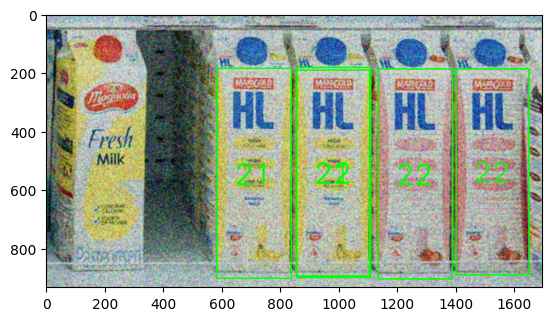

Processing scene11
Product ref17 - 3 instance(s) found:
Instance 1: position: (557, 369), width: 186px, height: 488px
Instance 2: position: (360, 369), width: 186px, height: 488px
Instance 3: position: (165, 366), width: 186px, height: 488px
Product ref23 - 3 instance(s) found:
Instance 1: position: (358, 365), width: 184px, height: 497px
Instance 2: position: (556, 364), width: 184px, height: 497px
Instance 3: position: (164, 360), width: 184px, height: 497px
Product ref24 - 3 instance(s) found:
Instance 1: position: (555, 372), width: 187px, height: 487px
Instance 2: position: (357, 371), width: 187px, height: 487px
Instance 3: position: (164, 367), width: 187px, height: 487px
Product ref25 - 3 instance(s) found:
Instance 1: position: (1344, 383), width: 192px, height: 499px
Instance 2: position: (1143, 381), width: 192px, height: 499px
Instance 3: position: (943, 379), width: 192px, height: 499px




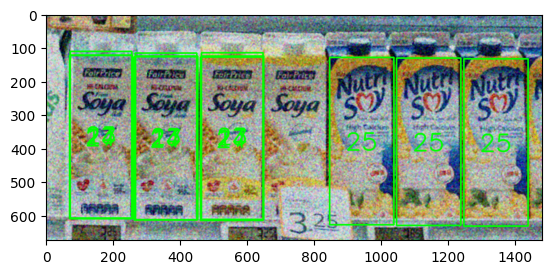

Processing scene12
Product ref26 - 2 instance(s) found:
Instance 1: position: (411, 398), width: 234px, height: 597px
Instance 2: position: (136, 387), width: 234px, height: 597px
Product ref27 - 1 instance(s) found:
Instance 1: position: (954, 401), width: 257px, height: 597px




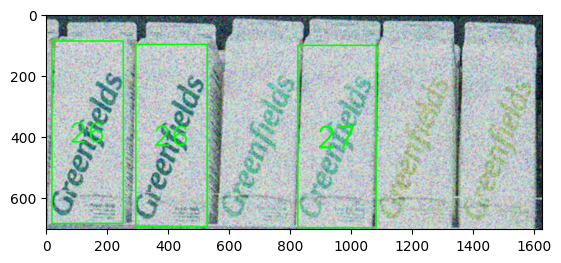

In [18]:
for scene_name, scene_img in preprocessed_scenes.items():
  print(f"Processing {scene_name}")
  results = {}

  for ref_name, ref_img  in ref_images.items():
    bounding_boxes = template_matching(scene_img, ref_img, scale_ranges=(0.4, 1.0))

    if bounding_boxes:
      product_id = os.path.splitext(ref_name)[0]
      results[product_id] = {
          "instances_found": len(bounding_boxes),
          "bounding_boxes": bounding_boxes
      }

  generate_output(results, scene_img, show_bounding_boxes=True, show_label=True)

In order to enhance the template matching to detect multiple instance, we need to slightly modify the algoritm.

In [ ]:
from scipy.signal import find_peaks
from skimage.feature import peak_local_max
import pandas as pd

def _findLocalMax_(corrMap, score_threshold=0.6):
  """Get coordinates of the local maximas with values above a threshold in the image of the correlation map."""
  # IF depending on the shape of the correlation map
  if corrMap.shape == (1,1): ## Template size = Image size -> Correlation map is a single digit')
    if corrMap[0,0]>=score_threshold:
      peaks = np.array([[0,0]])
    else:
      peaks = []

  # use scipy findpeaks for the 1D cases (would allow to specify the relative threshold for the score directly here rather than in the NMS
  elif corrMap.shape[0] == 1:     ## Template is as high as the image, the correlation map is a 1D-array
      peaks = find_peaks(corrMap[0], height=score_threshold) # corrMap[0] to have a proper 1D-array
      peaks = [[0,i] for i in peaks[0]] # 0,i since one coordinate is fixed (the one for which Template = Image)


  elif corrMap.shape[1] == 1: ## Template is as wide as the image, the correlation map is a 1D-array
      #peaks    = argrelmax(corrMap, mode="wrap")
      peaks = find_peaks(corrMap[:,0], height=score_threshold)
      peaks = [[i,0] for i in peaks[0]]


  else: # Correlation map is 2D
      peaks = peak_local_max(corrMap, threshold_abs=score_threshold, exclude_border=False).tolist()

  return peaks

In [ ]:
def template_matching(scene_img, model_img, th = 0.75, overlap_th = 0.25):
  # Initialize list to store bounding boxes
  listHit = []

  h_img, w_img = scene_img.shape[0:2]
  for scale in np.linspace(0.2, 1.0, 10):
    resized = imutils.resize(model_img, width = int(model_img.shape[1] * scale))
    r = model_img.shape[1] / float(resized.shape[1])

    if resized.shape[0] > h_img or resized.shape[1] > w_img:
      break

    height, width = resized.shape[0:2] # slicing make sure it works for RGB too

    res = cv2.matchTemplate(scene_img, resized, cv2.TM_CCOEFF_NORMED)
    peaks = _findLocalMax_(res, score_threshold = 0.5)
    for peak in peaks :
      listHit.append({'TemplateName':'Prova', 'BBox': ( int(peak[1]), int(peak[0]), width, height ) , 'Score':res[tuple(peak)]})

    if listHit:
      h = pd.DataFrame(listHit)
    else:
      h = pd.DataFrame(columns=["TemplateName", "BBox", "Score"])


  print(NMS(h, scoreThreshold=0.75, sortAscending=False, N_object=float("inf"), maxOverlap=overlap_th))

  return 0